# Ordered Logistic Regression

In [1]:
import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import scipy
import scipy.stats as stats
import seaborn as sns
from numpyro import handlers
from numpyro.infer.reparam import TransformReparam

numpyro.set_host_device_count(4)
az.style.use("arviz-darkgrid")

In [2]:
df = (
    pd.read_csv("~/Downloads/kaggle_survey_2020_responses.csv", header=[1])
    .iloc[:, [4, 7, 8]]
    .copy()
)

df.columns = ["education", "python", "R"]
df["python"] = ~df["python"].isna()
df["R"] = ~df["R"].isna()
df = df[
    df["education"].isin(
        [
            "Doctoral degree",
            "Master’s degree",
            "Bachelor’s degree",
            "No formal education past high school",
        ]
    )
].reset_index(drop=True)
df["education"] = df["education"].replace(
    "No formal education past high school", "High school"
)
np.random.seed(2)
df = df.sample(n=10_000).reset_index(drop=True)

In [3]:
df

,education,python,R
0,Doctoral degree,True,True
1,Bachelor’s degree,True,False
2,Doctoral degree,True,False
3,Bachelor’s degree,True,False
4,Master’s degree,False,False
...,...,...,...
9995,Bachelor’s degree,True,False
9996,Master’s degree,True,False
9997,Bachelor’s degree,False,False
9998,Master’s degree,True,False


In [4]:
education_to_index = {
    "High school": 0,
    "Bachelor’s degree": 1,
    "Master’s degree": 2,
    "Doctoral degree": 3,
}

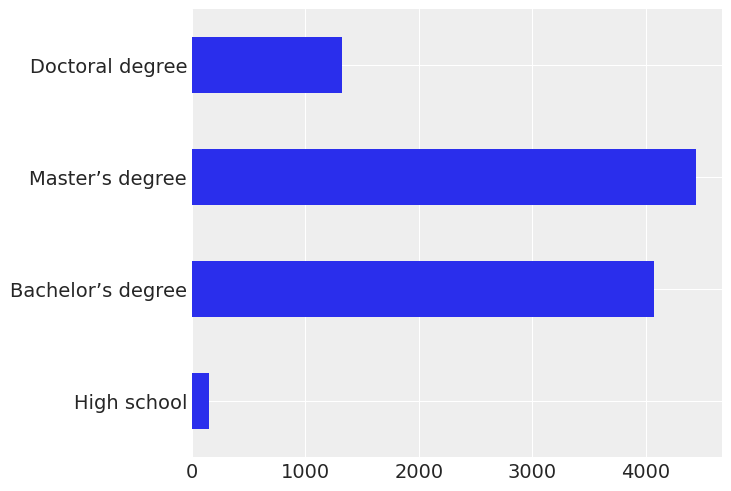

In [5]:
df["education"].value_counts().reindex(education_to_index).plot.barh();

## Categorical Distribution

In [8]:
# suppose we have the categories: 0, 1, and 2.
# 20% chance of a sample belonging to class 0
# 50% chance of a sample belonging to class 1
# 30% chance of a sample belonging to class 2
pd.Series(dist.Categorical(probs=jnp.array([.2, .5, .3])).sample(jax.random.PRNGKey(6), sample_shape=(100,))).value_counts(normalize=True).sort_index()

0    0.17
1    0.46
2    0.37
dtype: float64

## Back to our problem

Should be try predicting these probabilities directly?
Maybe not, maybe we need some additional structure to capture the ordering among them.

Define

    class 0: high school
    class 1: Bachelor's degree
    class 2: Master's degree
    class 3: Doctoral degree

We have the probabilities of each class

    p_0: probability of class 0
    p_1: probability of class 1
    p_2: probability of class 2
    p_3: probability of class 3
    
Take cumulative probabilities:

    q_0: probability of class 0
    q_1: probability of class 1 or class 0
    q_2: probability of class 2 or class 1 or class 0
    q_3: probability of class 3 or class 2 or class 1 or class 0 = 1
    
If we have `q`, then we can recover `p`:

    p_0 = q_0 - 0
    p_1 = q_1 - q_0
    p_2 = q_2 - q_1
    p_3 = 1 - q_2

We can transform between `q` and `logits` as

    logit_0 = logit(q_0)
    logit_1 = logit(q_1)
    logit_2 = logit(q_2)

Predict using our features

    prediction = model(features)
    
We can then find our cutpoints

    cutpoint_0 = logit_0 + prediction
    cutpoint_1 = logit_1 + prediction
    cutpoint_2 = logit_2 + prediction

In [12]:
def ordered_logistic_regression(python, R, n_education_levels, education=None):
    coefficient_neither = numpyro.sample(
        "coefficient_neither",
        dist.Normal(0, 1),
    )
    coefficient_python = numpyro.sample(
        "coefficient_python",
        dist.Normal(0, 1),
    )
    coefficient_R = numpyro.sample(
        "coefficient_R",
        dist.Normal(0, 1),
    )
    coefficient_R_and_python = numpyro.sample(
        "coefficient_R_and_python",
        dist.Normal(0, 1),
    )
    cutpoints = numpyro.sample(
        "cutpoints",
        dist.TransformedDistribution(
            dist.Normal(0, 1).expand([n_education_levels - 1]),
            dist.transforms.OrderedTransform(),
        ),
    )

    prediction = (
        coefficient_neither * np.where((python == 0) & (R == 0), 1, 0)
        + coefficient_python * np.where((python == 1) & (R == 0), 1, 0)
        + coefficient_R * np.where((python == 0) & (R == 1), 1, 0)
        + coefficient_R_and_python * np.where((python == 1) & (R == 1), 1, 0)
    )
    logits = cutpoints - prediction[:, jnp.newaxis]
    cumulative_probs = jnp.pad(
        jax.scipy.special.expit(logits),
        pad_width=((0, 0), (1, 1)),
        constant_values=(0, 1),
    )
    probs = numpyro.deterministic("probs", jnp.diff(cumulative_probs))

    numpyro.sample(
        "education",
        dist.Categorical(probs=probs),
        obs=education,
    )

## Prior predictive simulation

In [13]:
prior_pred = numpyro.infer.Predictive(ordered_logistic_regression, num_samples=100)
prior_predictions = prior_pred(
    jax.random.PRNGKey(93),
    python=np.array([0, 0, 1, 1]),
    R=np.array([0, 1, 0, 1]),
    n_education_levels=4,
)

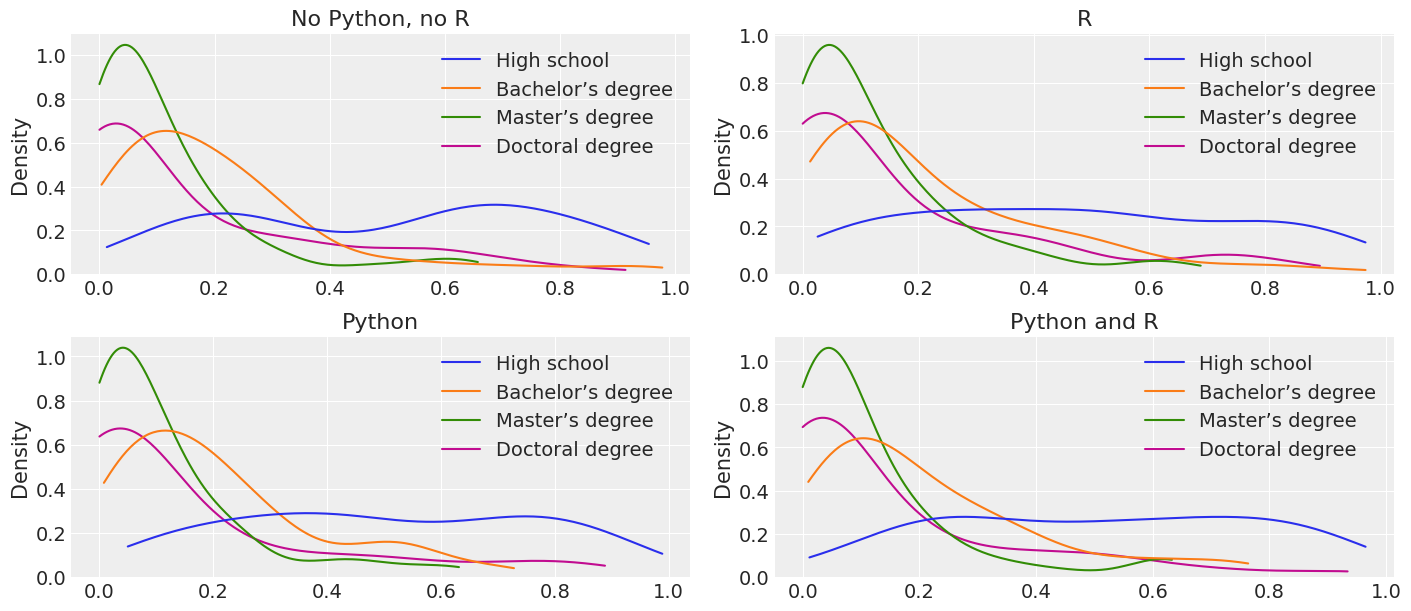

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 6))
ax = ax.flatten()
rows = {
    0: "No Python, no R",
    1: "R",
    2: "Python",
    3: "Python and R",
}

for row, description in rows.items():
    prior_df = pd.DataFrame(
        prior_predictions["probs"][:, row, :], columns=education_to_index
    )
    sns.kdeplot(data=prior_df, ax=ax[row], cut=0)
    ax[row].set_title(description)

## MCMC

In [15]:
sampler = numpyro.infer.NUTS(ordered_logistic_regression)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(93),
    python=df["python"].to_numpy(),
    R=df["R"].to_numpy(),
    n_education_levels=4,
    education=df["education"].map(education_to_index).to_numpy(),
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [16]:
mcmc.print_summary()


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
             coefficient_R      1.52      0.47      1.51      0.71      2.26    948.02      1.00
  coefficient_R_and_python      1.12      0.46      1.12      0.37      1.91    939.60      1.00
       coefficient_neither      0.38      0.47      0.39     -0.38      1.16    950.85      1.00
        coefficient_python      0.50      0.46      0.51     -0.22      1.31    933.99      1.00
              cutpoints[0]     -3.56      0.47     -3.57     -4.37     -2.81    946.19      1.00
              cutpoints[1]      0.32      0.46      0.32     -0.42      1.12    934.94      1.00
              cutpoints[2]      2.55      0.46      2.56      1.85      3.39    931.75      1.00

Number of divergences: 0


In [18]:
post_pred = numpyro.infer.Predictive(ordered_logistic_regression, mcmc.get_samples())
post_predictions = post_pred(
    jax.random.PRNGKey(93),
    python=np.array([0, 0, 1, 1]),
    R=np.array([0, 1, 0, 1]),
    n_education_levels=4,
)

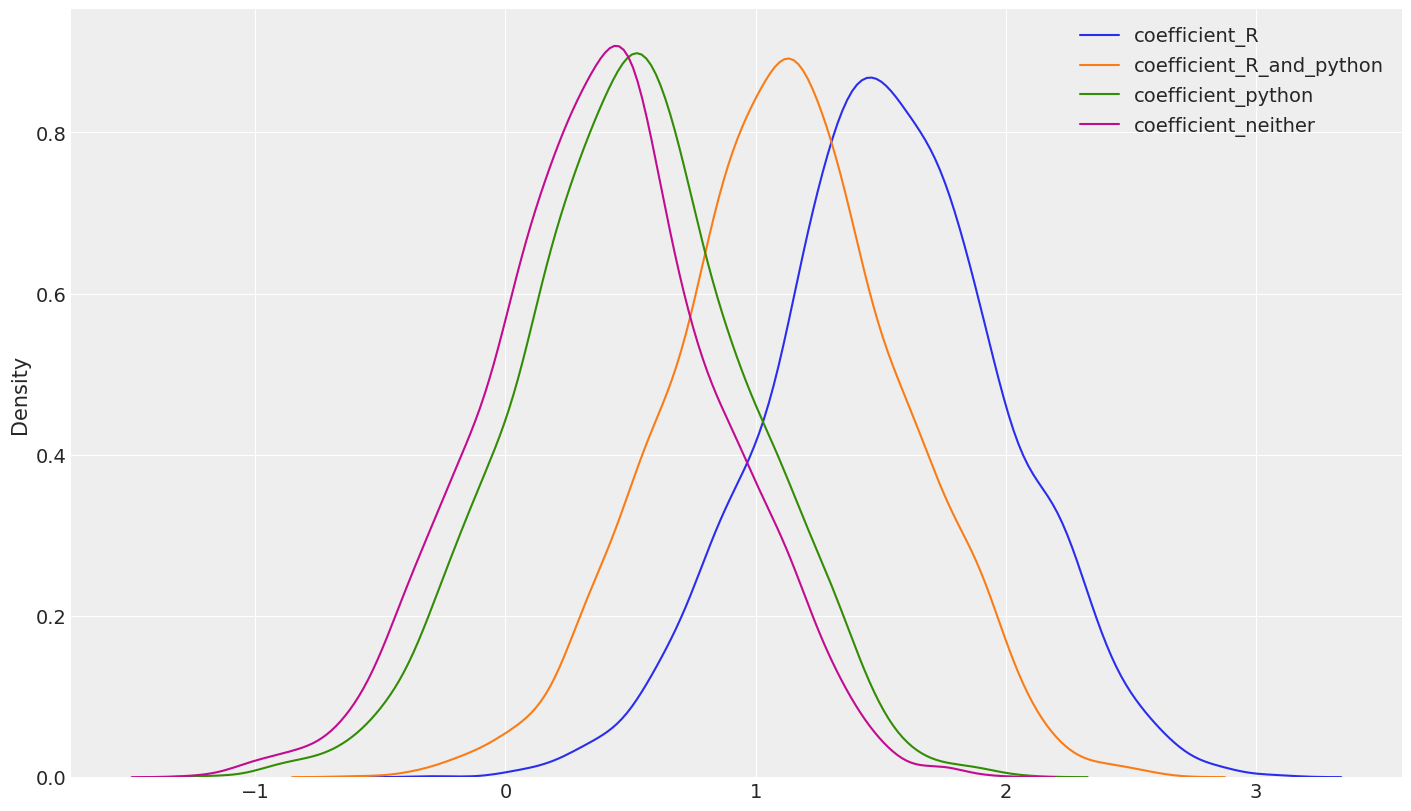

In [17]:
fig, ax = plt.subplots(figsize=(14, 8))
for coefficient in ['coefficient_R', 'coefficient_R_and_python', 'coefficient_python', 'coefficient_neither']:
    sns.kdeplot(mcmc.get_samples()[coefficient], ax=ax, label=coefficient)
ax.legend();

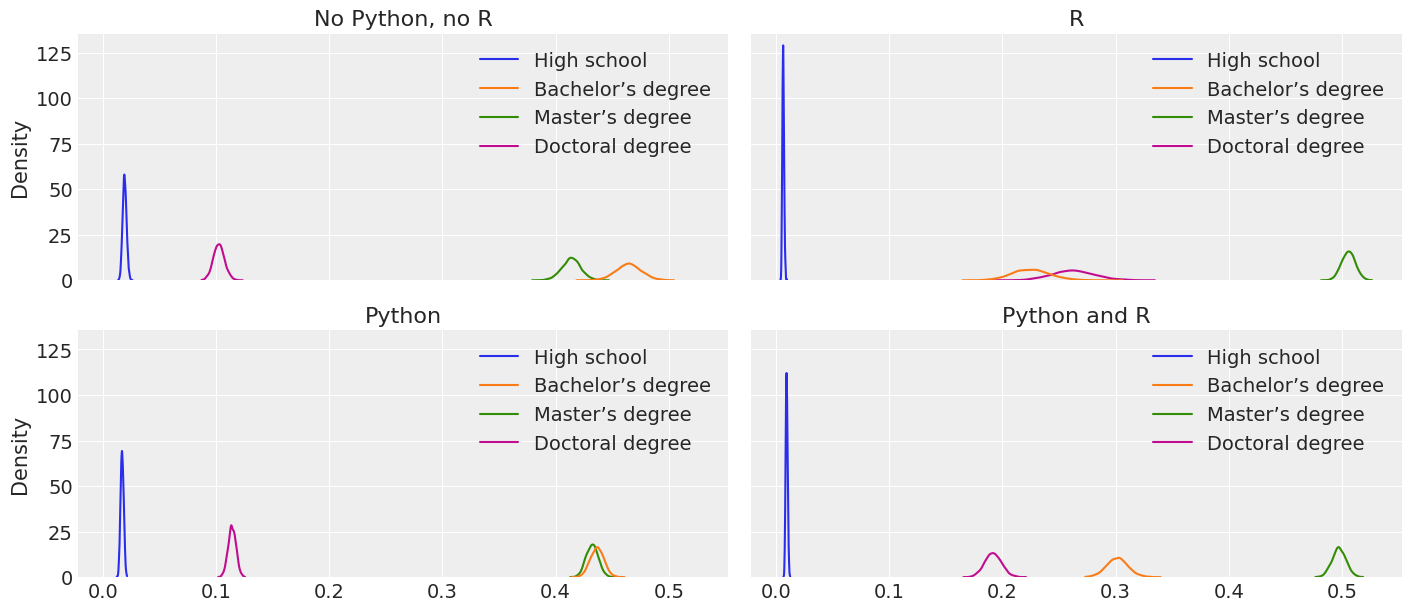

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 6), sharex=True, sharey=True)
ax = ax.flatten()
rows = {
    0: "No Python, no R",
    1: "R",
    2: "Python",
    3: "Python and R",
}

for row, description in rows.items():
    prior_df = pd.DataFrame(
        post_predictions["probs"][:, row, :], columns=education_to_index
    )
    sns.kdeplot(data=prior_df, ax=ax[row], cut=0)
    ax[row].set_title(description)

## Conclusion

- Use when your outcome has ordered categories (e.g. survey response, education level, ...)
- We implemented this in NumPyro
- NumPyro has the convenient `OrderedLogistic` class available

## Resources

Statistical Rethinking - Richard McElreath

Betancourt's case studies and podcast

Learning Bayesian Statistics podcast - Alex Andorra

pymc-examples notebooks

## At Gousto - we're hiring!

https://www.gousto.co.uk/jobs